# Testiranje modela minimizacijom najmanje svojstvene vrijednosti Laplaceovog operatora


[*Jupyter*](https://jupyter.org/) bilježnica Davora Penzara u sklopu diplomskog rada ($ 2020 $. godine na [*Matematičkom odsjeku*](https://www.math.pmf.unizg.hr/) [*Prirodoslovno-matematičkog fakulteta*](https://www.pmf.unizg.hr/) [*Sveučilišta u Zagrebu*](http://www.unizg.hr/)).

U ovoj su bilježnici testirani su istrenirani modeli strojnog učenja na mogućnosti minimizacije ciljne varijable po trokutima zadanog opsega.


## Sadržaj <a class="anchor" id="table-of-contents"></a>


1.  [Priprema okruženja](#environment-preparation)
    1.  [Učitavanje modela](#env-models-loading)
    2.  [Manipulacija trokutima](#env-triangles-manipulation)
2.  [Minimzacija $ \lambda_{1} $ za fiksni opseg trokuta](#fixed-circumference-lambda-minimisation)
3.  [Zaključak](#conclusion)


## Priprema okruženja <a class="anchor" id="environment-preparation"></a>


Učitavanje potrebnih paketa&hellip;


In [0]:
# Import IPython.
from IPython import *
from IPython.display import *


In [0]:
# Import standard library.
import copy
import enum
import functools
import gc
import math
import numbers
import random
import six
import sys
import time


In [0]:
# Import SciPy packages.
import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import scipy.optimize as opt
import sympy as sym
from mpl_toolkits.mplot3d import Axes3D


(izbriši `#` s početka sljedeće linije za učitavanje [*TensorFlow*](https://www.tensorflow.org/) verzije 2.x)


In [0]:
#%tensorflow_version 2.x


In [4]:
# Import TensorFlow.
import tensorflow as tf


In [0]:
# Import SciKit Learn.
import sklearn as sk
import sklearn.linear_model as lm


In [6]:
# Import Keras.
import keras
import keras.activations as ka
import keras.backend as K
import keras.callbacks as kc
import keras.layers as kl
import keras.losses as ke
import keras.models as km
import keras.optimizers as ko


Using TensorFlow backend.


In [0]:
# Import joblib.
import joblib as jl


Za spajanje na [*Google Drive*](https://drive.google.com/) učitaj i sljedeće pakete (ako se [*Jupyter*](https://jupyter.org/) bilježnica izvršava lokalno, sljedeća čelija nije potrebna, ali se sadržaj kasnijih čelija mora mijenjati).


In [0]:
# Import Google Colab.
import google
import google.colab as colab


Namještavanje okruženja&hellip;


In [0]:
%matplotlib inline


In [0]:
#sym.init_printing()


In [0]:
plt.style.use('default')


Spajanje na [*Google Drive*](https://drive.google.com/)&hellip;


In [11]:
colab.drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Navigiranje u direktorij na [*Google Drive*u](https://drive.google.com/)&hellip;


In [12]:
%cd '/content/drive/My Drive/destination_folder'


/content/drive/My Drive/destination_folder


(izbriši `#` s početka sljedeće linije za kloniranje [*GitHub*](https://github.com/) repozitorija s potrebnim materijalima)


In [0]:
#!git clone https://github.com/DavorPenzar/diplomski.git


Navigiranje u direktorij kloniranog [*GitHub*](https://github.com/) repozitorija&hellip;


In [13]:
%cd diplomski


/content/drive/My Drive/destination_folder/diplomski


Dohvaćanje najnovije verzije [*GitHub*](https://github.com/) repozitorija&hellip;


In [0]:
!git fetch


In [15]:
!git pull origin


Already up to date.


Navigiranje u poddirektorij s k&ocirc;dovima&hellip;


In [16]:
%cd code


/content/drive/My Drive/destination_folder/diplomski/code


Učitavanje vlastitih [*Python*](https://www.python.org/) skripti&hellip;


In [0]:
from usefulness import *
from MST_CNN import *


Definiranje pomoćne funkcije za konstruiranje članova polinoma&hellip;


In [0]:
def polynomial_terms_creator (n):
    """
    Construct a function for generating variables of a polynomial of degree n in
    two variables.

    """

    # Construct the function.
    def polynomial_terms (x, y):
        # Initialise the list of terms to `None`s.
        terms = list(None for i in six.moves.range((n + 2) * (n + 1) // 2 - 1))
        try:
            del i
        except (NameError, UnboundLocalError):
            pass

        # Initialise the index to 0.
        i = 0

        # Construct the terms.
        for k in six.moves.range(1, n + 1):
            # Construct the term `x ** k` and increment the index `i`.
            terms[i] = (x ** k if k > 1 else x)
            i += 1

            # Construct all terms `x ** (k - r) * y ** r` for `r` in
            # [2 .. k - 1] and increment the index `i` after creating each term.
            for r in six.moves.range(1, k):
                terms[i] = (
                    (x ** (k - r) if k - r > 1 else x) *
                    (y ** r if r > 1 else y)
                )
                i += 1

            # Construct the term `y ** k`.
            terms[i] = (y ** k if k > 1 else y)
            i += 1
        try:
            del k
        except (NameError, UnboundLocalError):
            pass

        # Free the memory.
        del i

        # Return the constructed list of terms.
        return terms

    # Return the constructed function.
    return polynomial_terms


Definiranje vlastite aktivacijske funkcije `ReLU`$ {} \circ x \mapsto x^{{- 1}} $&hellip;


In [0]:
def relu_mult_inv (x):
    """
    Return `relu(x ** -1)`.

    """

    return K.relu(K.pow(x, -1))


### Učitavanje modela <a class="anchor" id="env-models-loading"></a>


**Učitavanje polinoma&hellip;**


In [0]:
# Load the models.
polynomial_4 = jl.load('models/polynomial_4.gz')
polynomial_5 = jl.load('models/polynomial_5.gz')

# Construct the functions to create polynomial terms.
polynomial_terms_4 = polynomial_terms_creator(4)
polynomial_terms_5 = polynomial_terms_creator(5)


**Učitavanje neuronske mreže&hellip;**


In [21]:
# Load the model.
nn = km.load_model(
    'models/neural_network.h5',
    custom_objects = {'relu_mult_inv' : relu_mult_inv}
)

# Load the features' mean and standard deviation for normalisation.
X_mean = np.load('models/neural_network_features_mean.npy')
X_std = np.load('models/neural_network_features_std.npy')











Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




**Učitavanje konvolucijske neuronske mreže&hellip;**


In [0]:
# Load the model.
cnn = km.load_model('models/convolutional_neural_network.h5')

# Load the resolution of the visualisations for the convolutional neural
# network.
res = -1
with (
    open('models/convolutional_neural_network_resolution.txt', 'rt')
) as resolution_input:
    res = int(resolution_input.readline().strip())
try:
    del resolution_input
except (NameError, UnboundLocalError):
    pass


### Manipulacija trokutima <a class="anchor" id="env-triangles-manipulation"></a>


Definiranje pomoćnih funkcija za manipulaciju trokutima (pretprocesija za modele koja je inače napisana u programskom jeziku [*C*](https://en.cppreference.com/w/c/header))&hellip;


In [0]:
def correct_orientation (T):
    """
    Correct the orientation of the enumeration of vertices of a triangle.

    Returns
    =======
    (6,) array.
        The array of the coordinates of vertices of the triangle such that the
        first vertex is the one with the minimal y-coordinate (and the maximal
        x-coordinate if there are ties) and whose vertices are enumerated
        positively oriented.

    Notes
    =====
    The original array `T` must be of shape `(6,)`.  The original array and the
    resulting array represent a triangle by defining its vertices' coordinates
    as `[x_0, y_0, x_1, y_1, x_2, y_2]`, where (`x_i`, `y_i`) are coordinates of
    the `i`-th vertex.

    """

    # Initialise the index of the correctly first vertex's x-coordinate to 0.
    v = 0

    # Find the index of the correctly first vertex's x-coordinate.
    for i in six.moves.range(2, 5, 2):
        if T[i + 1] < T[v + 1] or (T[i + 1] == T[v + 1] and T[i] < T[v]):
            v = i
    try:
        del i
    except (NameError, UnboundLocalError):
        pass

    # Construct the array of the coordinates so that the correctly first vertex
    # is the first vertex.
    T = np.array(
        np.roll(T, -v) if v else T,
        dtype = float,
        copy = True,
        order = 'C'
    )

    # Free the memory.
    del v

    # If necessary, permute the coordinates so that they are enumerated
    # positively oriented.
    if (T[0] - T[4]) * (T[3] - T[5]) - (T[2] - T[4]) * (T[1] - T[5]) < 0:
        T[2:5:2] = T[4:1:-2]
        T[3:6:2] = T[5:2:-2]

    # Return the array of coordinates.
    return T


In [0]:
def edges_lengths (T):
    """
    Compute the lengths of edges of a triangle.

    Returns
    =======
    a : float
        Length of the edge from the first to the second vertex.

    b : float
        Length of the edge from the second to the third vertex.

    c : float
        Length of the edge from the third to the first vertex.

    Notes
    =====
    The array `T` must be of shape `(6,)`.  The array represents a triangle by
    defining its vertices' coordinates as `[x_0, y_0, x_1, y_1, x_2, y_2]`,
    where (`x_i`, `y_i`) are coordinates of the `i`-th vertex.

    """

    return (
        math.sqrt((T[2] - T[0]) ** 2 + (T[3] - T[1]) ** 2),
        math.sqrt((T[4] - T[2]) ** 2 + (T[5] - T[3]) ** 2),
        math.sqrt((T[0] - T[4]) ** 2 + (T[1] - T[5]) ** 2)
    )


In [0]:
def outer_angles (a, b, c):
    """
    Compute the outer angles of a triangle of sides `a`, `b`, `c`.

    Returns
    =======
    alpha : float
        The outer angle at the vertex opposite of the side `a`.

    beta : float
        The outer angle at the vertex opposite of the side `b`.

    gamma : float
        The outer angle at the vertex opposite of the side `c`.

    """

    # Initialise the angles to zeros.
    alpha = 0.0
    beta = 0.0
    gamma = 0.0

    # If `a` is the largest side, compute the angles.
    if a >= b and a >= c:
        # Conduct the first steps to compute the inner angle `alpha` using the
        # cosine law.
        V = (b ** 2 + c ** 2 - a ** 2) / (2.0 * b * c)

        # If `V` is less than -1.0, set the inner angle `alpha` to pi.
        if V <= -1.0:
            alpha = math.pi
        # Otherwise, if `V` is in the range [-1, 1], compute the angles.
        elif V > -1.0 and V < 1.0:
            # Compute the inner angle `alpha` using the cosine law.
            alpha = math.acos(V)

            # Compute `sin(alpha)`.
            sin_alpha = math.sin(alpha)

            # Compute the inner angles `beta` and `gamma` using the sine law.
            beta = math.asin(b / a * sin_alpha)
            gamma = math.asin(c / a * sin_alpha)

            # Free the memory.
            del sin_alpha

            # Compute the outer angles by subtracting the inner angles from pi.
            alpha = math.pi - alpha
            beta = math.pi - beta
            gamma = math.pi - gamma

        # Free the memory.
        del V
    # Otherwise, use the inner angles of the triangle of sides `b`, `c`, `a`.
    else:
        beta, gamma, alpha = outer_angles(b, c, a)

    # Return the computed angles.
    return (alpha, beta, gamma)


In [0]:
def sort_edges_angles (a, b, c, alpha, beta, gamma):
    """
    Sort the lengths of edges and the outer angles of a triangle.

    The lengths of edges are sorted descendingly, while the outer angles are
    sorted ascendingly.  It is believed that the outer angle `alpha` is at the
    vertex oposite of the side `a`, the outer angle `beta` is at the vertex
    oppostie of the side `b` and the outer angle `gamma` is at the vertex
    opposite of the side `c` (the angles are not compared, they are sorted
    parallel to the sorting of the lengths of edges).

    Returns
    =======
    a_ : float
        The longest side.

    c_ : float
        The second longest/second shortest side.

    b_ : float
        The shortest side.

    alpha_ : float
        The smallest outer angle.

    gamma_ : float
        The second smallest/second largest outer angle.

    beta_ : float
        The largest outer angle.

    """

    # Sort the lengths of edges and the outer angles.
    if a < b:
        a, b = (b, a)
        alpha, beta = (beta, alpha)
    if a < c:
        a, c = (c, a)
        alpha, gamma = (gamma, alpha)
    if b > c:
        c, b = (b, c)
        gamma, beta = (beta, gamma)

    # Return the sorted values.
    return (a, c, b, alpha, gamma, beta)


In [0]:
def characteristic (a, c, b, alpha, gamma, beta, norm = False):
    """
    Compute the coordinates of the characteristic point of a triangle.

    If `norm` is true, it is assumed that the longest side of the triangle is of
    length 1 (that the triangle is of diameter 1).  Otherwise additional
    computation is done.

    The lengths of edges `a`, `c`, `b` should be sorted descendingly, while the
    outer angles `alpha`, `gamma`, `beta` should be sorted ascendingly.  Use the
    function `sort_edges_angles` to ensure this.

    Returns
    =======
    x : float
        The x-coordinate of the characteristic point.

    y : float
        The y-coordinate of the characteristic point.

    """

    # If the triengles edges are not normed, divide `b` by `a`.
    if not norm:
        b /= a

    # Compute and return the characteristic point's coordinates.
    return (0.5 * b * math.cos(gamma), b * math.sin(gamma))


In [0]:
def svd (x, y, z):
    """
    Return the singular values of a triangle.

    If `x`, `y` and `z` are the lengths of edges of a triangle, the singular
    values of the lengths of edges are returned.  If `x`, `y` and `z` are the
    outer angles of a triangle, the singular values of the outer angles are
    returned.

    Returns
    =======
    (3,) array
        The singular values sorted descendingly.

    """

    # Construct an auxiliary matrix of the unoriented representation of the
    # array `[x, y, z]`.
    A = np.array(
        [
            [x, y, z],
            [z, y, x],
            [y, z, x],
            [x, z, y],
            [z, x, y],
            [y, x, z]
        ],
        dtype = float,
        copy = True,
        order = 'C'
    )

    # Compute the singular values of the matrix `A`.  Those close to 0 set to
    # 0 sharp.
    sv = np.linalg.svd(A, full_matrices = False, compute_uv = False)
    sv[np.isclose(1.0, 1.0 + sv)] = 0.0

    # Free the memory.
    del A

    # Sort the singular values descendingly.
    sv = np.array(np.sort(sv.ravel()), dtype = float, copy = True, order = 'C')

    # Return the computed singular values.
    return sv


In [0]:
def centralise (T, a, b, c):
    """
    Centralise a triangle so that its incircle's center is at (0, 0).

    Returns
    =======
    (6,) array
        Coordinates of the triangle constructed by translating the original
        triangel `T` so that its incircle's center is at (0, 0).

    Notes
    =====
    The original array `T` must be of shape `(6,)`.  The original array and the
    resulting array represent a triangle by defining its vertices' coordinates
    as `[x_0, y_0, x_1, y_1, x_2, y_2]`, where (`x_i`, `y_i`) are coordinates of
    the `i`-th vertex.  It is believed that `a`, `b`, `c` are the lengths of the
    triangle's edges so that `a` spans from (`x_0`, `y_0`) to (`x_1`, `y_1`),
    `b` spans from (`x_1`, `y_1`) to (`x_2`, `y_2`) and `c` spans from
    (`x_2`, `y_2`) to (`x_0`, `y_0`).

    """

    # Compute the circumference of the triangle.
    C = a + b + c

    # Compute the coordinates of the incircle's center.
    x = (b * T[0] + c * T[2] + a * T[4]) / C
    y = (b * T[1] + c * T[3] + a * T[5]) / C

    # Free the memory.
    del C

    # Construct a new triangle by translating the original triangle.
    T = np.array(
        [T[0] - x, T[1] - y, T[2] - x, T[3] - y, T[4] - x, T[5] - y],
        dtype = float,
        copy = True,
        order = 'C'
    )

    # Free the memory.
    del x
    del y

    # Return the newly constructed triangle.
    return T


In [0]:
def construct (a, b, c, alpha, beta, gamma):
    """
    Construct a triangle with defined lengths of edges and outer angles.

    Returns
    =======
    (6,) array
        Coordinates of the triangle.  It is guaranteed that the triangle's
        incircle's center is at (0, 0) (up to a numerical precision).

    Notes
    =====
    The resulting array represents a triangle by defining its vertices'
    coordinates as `[x_0, y_0, x_1, y_1, x_2, y_2]`, where (`x_i`, `y_i`) are
    coordinates of the `i`-th vertex.

    """

    # Initialise the coordinates to zeros.
    T = np.zeros(tuple([6]), dtype = float, order = 'C')

    # Construct a triangle whose one sides lies on the negative part of the
    # x-axis and ends in the origin, and whose third vertex has a non-negative
    # y-coordinate.
    T[0] = -c
    T[4] = math.cos(beta) * a
    T[5] = math.sin(beta) * a

    # Compute a random angle in the interval [0, 2 * pi).
    phi = 2.0 * random.random() * math.pi

    # Compute the cosine and the sine of the angle.
    cos_phi = math.cos(phi)
    sin_phi = math.sin(phi)

    # Rotate the triangle around the origin by the angle `phi`.
    for i in six.moves.range(0, 5, 2):
        T[i], T[i + 1] = (
            cos_phi * T[i] - sin_phi * T[i + 1],
            sin_phi * T[i] + cos_phi * T[i + 1]
        )
    try:
        del i
    except (NameError, UnboundLocalError):
        pass

    # Free the memory.
    del phi

    # Centralise the triangle using the `centralise` function.
    T = centralise(T, a, b, c)

    # Return the constructed triangle.
    return T


## Minimizacija $ \lambda_{1} $ za fiksni opseg trokuta <a class="anchor" id="fixed-circumference-lambda-minimisation"></a>


Konstruiranje funkcija za provjeru vrijednosti (parametar `constraints`) u funkciji [`scipy.optimize.optimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)&hellip;


In [0]:
def minimal_edge (T):
    """
    Returns the length of the shortest side of a triangle.

    Notes
    =====
    The array `T` must be of shape `(6,)`.  The array represents a triangle by
    defining its vertices' coordinates as `[x_0, y_0, x_1, y_1, x_2, y_2]`,
    where (`x_i`, `y_i`) are coordinates of the `i`-th vertex.

    """

    return min(edges_lengths(T))

def circumference_difference (T, C):
    """
    Returns the absolute difference of a triangle's circumference and a target circumference.

    Notes
    =====
    The array `T` must be of shape `(6,)`.  The array represents a triangle by
    defining its vertices' coordinates as `[x_0, y_0, x_1, y_1, x_2, y_2]`,
    where (`x_i`, `y_i`) are coordinates of the `i`-th vertex.

    The target circumference `C` should be a strictly positive real number.

    """

    return abs(sum(edges_lengths(T)) - C)


Definiranje funkcije za minimizaciju (parametar `fun`) u funkciji [`scipy.optimize.optimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) modelom linearne regresije&hellip;


In [0]:
def polynomial_objective (T, deg = 4):
    """
    Approximate the minimal eigenvalue of Dirichlet Laplacian on a triangle.

    The eigenvalue is approximated using one of the polynomial models.  The
    degree of the polynomial is set with the parameter `deg`.

    Notes
    =====
    The array `T` must be of shape `(6,)`.  The array represents a triangle by
    defining its vertices' coordinates as `[x_0, y_0, x_1, y_1, x_2, y_2]`,
    where (`x_i`, `y_i`) are coordinates of the `i`-th vertex.

    """

    # Correct the orientation of the enumeration of vertices.
    T = correct_orientation(T)

    # Compute the lengths of edges of the triangle.
    a, b, c = edges_lengths(T)

    # Compute the diameter of the triangle, i. e. the length of its longest
    # side.
    d = max(a, b, c)

    # Normalise the triangle's edges by dividing them by `d`.
    a /= d
    b /= d
    c /= d

    # Compute the outer angles of the triangle.
    alpha, beta, gamma = outer_angles(a, b, c)

    # Sort the lengths of edges and the outer angles.
    a, c, b, alpha, gamma, beta = sort_edges_angles(a, b, c, alpha, beta, gamma)

    # Compute the coordinates of the characteristic point of the triangle.
    x, y = characteristic(a, c, b, alpha, gamma, beta, norm = True)

    # Free the memory.
    del a
    del b
    del c
    del alpha
    del beta
    del gamma

    # Approximate the minimal eigenvalue of the Dirichlet Laplacian on the
    # triangle.
    l_0 = float(
        d ** -2 * (
            polynomial_4.predict(
                np.array(
                    [polynomial_terms_4(x, y)],
                    dtype = float,
                    copy = True,
                    order = 'C'
                )
            ) if deg == 4 else polynomial_5.predict(
                np.array(
                    [polynomial_terms_5(x, y)],
                    dtype = float,
                    copy = True,
                    order = 'C'
                )
            ) if deg == 5 else float('nan')
        ) ** -1
    )

    # Free the memory.
    del d
    del x
    del y

    # Return the approximation of the minimal eigenvalue of the Dirichlet
    # Laplacian on the triangle.
    return l_0


In [0]:
# Define objective functions for polynomials as partial functions of the
# `polynomial_objective` function.
polynomial_4_objective = functools.partial(polynomial_objective, deg = 4)
polynomial_5_objective = functools.partial(polynomial_objective, deg = 5)


Definiranje funkcije za minimizaciju (parametar `fun`) u funkciji [`scipy.optimize.optimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) modelom neuronske mreže&hellip;


In [0]:
def nn_objective (T):
    """
    Approximate the minimal eigenvalue of Dirichlet Laplacian on a triangle.

    The eigenvalue is approximated using the neural network.

    Notes
    =====
    The array `T` must be of shape `(6,)`.  The array represents a triangle by
    defining its vertices' coordinates as `[x_0, y_0, x_1, y_1, x_2, y_2]`,
    where (`x_i`, `y_i`) are coordinates of the `i`-th vertex.

    """

    # Correct the orientation of the enumeration of vertices.
    T = correct_orientation(T)

    # Compute the diameter of the triangle, i. e. the length of its longest
    # side.
    d = max(edges_lengths(T))

    # Normalise the triangle so that its diameter equals 1.
    T /= d

    # Compute the lengths of edges of the normalised triangle.
    a, b, c = edges_lengths(T)

    # Compute the outer angles of the triangle.
    alpha, beta, gamma = outer_angles(a, b, c)

    # Compute the singular values of the lengths of edges and of the outer
    # angles of the (normalised) triangle.
    sv_edges = svd(a, b, c)
    sv_angles = svd(alpha, beta, gamma)

    # Sort the lengths of edges and the outer angles.
    a, c, b, alpha, gamma, beta = sort_edges_angles(a, b, c, alpha, beta, gamma)

    # Approximate the minimal eigenvalue of the Dirichlet Laplacian on the
    # triangle.
    l_0 = float(
        d ** -2 *
        nn.predict(
            np.array(
                [
                    (
                        [
                            c,
                            b,
                            alpha,
                            gamma,
                            beta,
                            sv_edges[0],
                            sv_edges[1],
                            sv_angles[1]
                        ] - X_mean
                    ) / X_std
                ],
                dtype = float,
                copy = True,
                order = 'C'
            ),
            verbose = 0
        )
    )

    # Free the memory.
    del a
    del b
    del c
    del alpha
    del beta
    del gamma
    del sv_edges
    del sv_angles
    del d

    # Return the approximation of the minimal eigenvalue of the Dirichlet
    # Laplacian on the triangle.
    return l_0


Definiranje funkcije za minimizaciju (parametar `fun`) u funkciji [`scipy.optimize.optimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) modelom konvolucijske neuronske mreže&hellip;


In [0]:
def cnn_objective (T):
    """
    Approximate the minimal eigenvalue of Dirichlet Laplacian on a triangle.

    The eigenvalue is approximated using the convolutional neural network.

    Notes
    =====
    The array `T` must be of shape `(6,)`.  The array represents a triangle by
    defining its vertices' coordinates as `[x_0, y_0, x_1, y_1, x_2, y_2]`,
    where (`x_i`, `y_i`) are coordinates of the `i`-th vertex.

    """

    # Correct the orientation of the enumeration of vertices.
    T = correct_orientation(T)

    # Compute the diameter of the triangle, i. e. the length of its longest
    # side.
    d = max(edges_lengths(T))

    # Normalise the triangle so that its diameter equals 1.
    T /= d

    # Compute the lengths of edges of the normalised triangle.
    a, b, c = edges_lengths(T)

    # Approximate the minimal eigenvalue of the Dirichlet Laplacian on the
    # triangle.
    l_0 = float(
        d ** -2 *
        cnn.predict(
            np.array(
                [
                    visualise_triangle(
                        centralise(T, a, b, c),
                        bbox = [[-1.0, -1.0], [1.0, 1.0]],
                        m = res + 1,
                        n = res + 1
                    )[:, :, np.newaxis]
                ],
                dtype = float,
                copy = True,
                order = 'C'
            ),
            verbose = 0
        )
    )

    # Free the memory.
    del a
    del b
    del c
    del d

    # Return the approximation of the minimal eigenvalue of the Dirichlet
    # Laplacian on the triangle.
    return l_0


Definiranje funkcije za kreiranje inicijalnog trokuta&hellip;


In [0]:
def initial_guess (min_edge = 0.5, min_angle = 0.25 * math.pi):
    """
    Create a triangle by defining its vertices.

    Triangles will be generated until the minimal edge is at least `min_edge`
    and the minimal outer angle is at least `min_angle`.

    Returns
    =======
    (6,) array
        The array of the coordinates of vertices of the triangle.

    Notes
    =====
    The resulting array represents a triangle by defining its vertices'
    coordinates as `[x_0, y_0, x_1, y_1, x_2, y_2]`, where (`x_i`, `y_i`) are
    coordinates of the `i`-th vertex.

    """

    # Initialise the array of vertices to `None`.
    T0 = None

    # Generate triangles.
    while True:
        # Generate an array of coordinates.
        T0 = np.array(
            np.random.randn(6),
            dtype = float,
            copy = True,
            order = 'C'
        )

        # Correct the orientation of the enumeration of the triangle's
        # vertices.
        T0 = correct_orientation(T0)

        # Compute the lengths of edges of the triangle.
        a, b, c = edges_lengths(T0)

        # Check if the minimal edge length is at least `min_edge`.  If it is,
        # continue to the next iteration.
        if min(a, b, c) < min_edge:
            # Free the memory.
            try:
                del a
            except (NameError, UnboundLocalError):
                pass
            try:
                del b
            except (NameError, UnboundLocalError):
                pass
            try:
                del c
            except (NameError, UnboundLocalError):
                pass

            # Continue to the next iteration.
            continue

        # Compute the outer angles of the triangle.
        alpha, beta, gamma = outer_angles(a, b, c)

        # Check if the minimal outer angle is at least `min_angle`.  If it is,
        # break the `while`-loop.
        if min(alpha, beta, gamma) >= min_angle:
            # Centralise the triangle.
            T0 = centralise(T0, a, b, c)

            # Free the memory.
            try:
                del a
            except (NameError, UnboundLocalError):
                pass
            try:
                del b
            except (NameError, UnboundLocalError):
                pass
            try:
                del c
            except (NameError, UnboundLocalError):
                pass
            try:
                del alpha
            except (NameError, UnboundLocalError):
                pass
            try:
                del beta
            except (NameError, UnboundLocalError):
                pass
            try:
                del gamma
            except (NameError, UnboundLocalError):
                pass

            # Break the `while`-loop.
            break

    # Return the generated triangle.
    return T0


**Konstruiranje inicijalnog pokušaja trokuta&hellip;**


In [0]:
# Initialise the initial guess to `None`.
T0 = None

# Generate the initial guess.
while True:
    # Construct an initial guess for the triangle.
    T0 = initial_guess()

    # Compute the circumference of the initial guess.
    C = sum(edges_lengths(T0))

    # Scale the initial guess so that its circumference equals 3.
    T0 = 3.0 * T0 / C
    T0 = centralise(T0, *edges_lengths(T0))

    # Free the memory.
    del C

    # If all vertices are inside the open rectangle (-1, 1) x (-1, 1), break the
    # `while`-loop (an OK initial guess was generated).
    if np.absolute(T0).max() < 1.0:
        break

# Define a constraint on the triangle's circumference (it should be as close 
# to 3 as possible, if not equal).
ok_circumference = functools.partial(circumference_difference, C = 3.0)


Vizualiziranje inicijalnog pokušaja&hellip;


array([[ 0.19956709, -0.34007414],
       [ 0.29404964,  0.3123716 ],
       [-0.87321696,  0.07062069]])

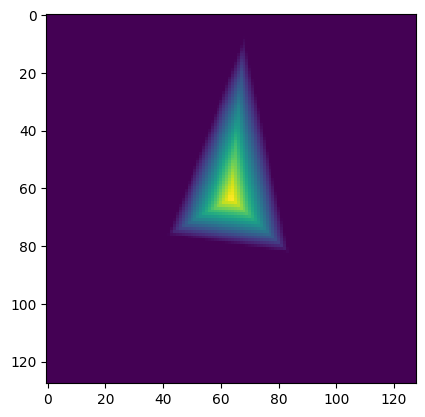

In [38]:
# Create a figure.
fig = plt.figure(num = 'Initial guess')

# Create a subplot.
ax = fig.add_subplot(1, 1, 1)

# Visualise the initial guess.
ax.imshow(
    visualise_triangle(T0, bbox = [[-1, -1], [1, 1]], m = res + 1, n = res + 1)
)

# Show the coordinates of the initial guess.
display(T0.reshape((3, 2)))

# Show the plots.
plt.show()


In [0]:
# Free the memory.
del fig
del ax


**Minimiziranje $ \lambda_{1} $ polinomom stupnja $ 4 $&hellip;**


In [40]:
min_l_0_triangle = opt.minimize(
    polynomial_4_objective,
    T0,
    method = 'trust-constr',
    bounds = ((-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1)),
    constraints = (
        {'type' : 'ineq', 'fun' : minimal_edge},
        {'type' : 'eq', 'fun' : ok_circumference}
    )
)


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning

In [0]:
T = correct_orientation(min_l_0_triangle.x)


array([[ 0.14459994, -0.54576955],
       [ 0.24233128,  0.47119122],
       [-0.64200207,  0.10616442]])

(1.021646039392396, 0.9567079218189605, 1.0216460387886515)

54.15141263053482

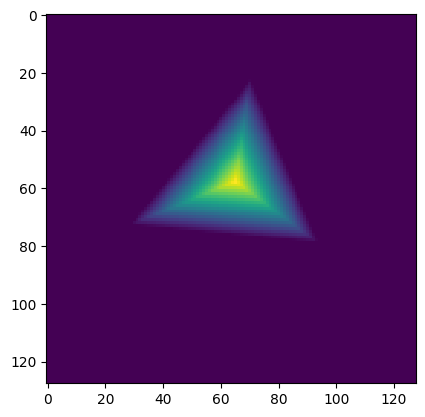

In [42]:
# Create a figure.
fig = plt.figure(num = 'Initial guess')

# Create a subplot.
ax = fig.add_subplot(1, 1, 1)

# Visualise the initial guess.
ax.imshow(
    visualise_triangle(T, bbox = [[-1, -1], [1, 1]], m = res + 1, n = res + 1)
)

# Show the coordinates of the resulting triangle, its lengths of edges and the
# approximation of the minimal Eigenvalue.
display(T.reshape((3, 2)))
display(edges_lengths(T))
display(polynomial_4_objective(T))

# Show the plots.
plt.show()


In [0]:
# Free the memory.
del fig
del ax


In [0]:
# Free the memory.
del min_l_0_triangle
del T


**Minimiziranje $ \lambda_{1} $ polinomom stupnja $ 5 $&hellip;**


In [45]:
min_l_0_triangle = opt.minimize(
    polynomial_5_objective,
    T0,
    method = 'trust-constr',
    bounds = ((-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1)),
    constraints = (
        {'type' : 'ineq', 'fun' : minimal_edge},
        {'type' : 'eq', 'fun' : ok_circumference}
    )
)


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning

In [0]:
T = correct_orientation(min_l_0_triangle.x)


array([[ 0.16015621, -0.50090576],
       [ 0.22628191,  0.49690554],
       [-0.67091087,  0.05526644]])

(1.0000000017582726, 0.9999999969804941, 1.0000000012612333)

53.18340529394229

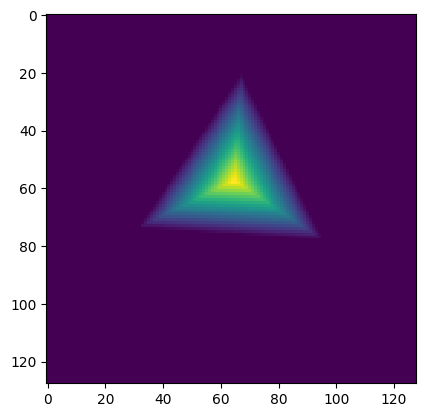

In [47]:
# Create a figure.
fig = plt.figure(num = 'Initial guess')

# Create a subplot.
ax = fig.add_subplot(1, 1, 1)

# Visualise the initial guess.
ax.imshow(
    visualise_triangle(T, bbox = [[-1, -1], [1, 1]], m = res + 1, n = res + 1)
)

# Show the coordinates of the resulting triangle, its lengths of edges and the
# approximation of the minimal Eigenvalue.
display(T.reshape((3, 2)))
display(edges_lengths(T))
display(polynomial_5_objective(T))

# Show the plot.
plt.show()


In [0]:
# Free the memory.
del fig
del ax


In [0]:
# Free the memory.
del min_l_0_triangle
del T


**Minimiziranje $ \lambda_{1} $ neuronskom mrežom&hellip;**


In [50]:
min_l_0_triangle = opt.minimize(
    nn_objective,
    T0,
    method = 'trust-constr',
    bounds = ((-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1)),
    constraints = (
        {'type' : 'ineq', 'fun' : minimal_edge},
        {'type' : 'eq', 'fun' : ok_circumference}
    )
)


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


In [0]:
T = correct_orientation(min_l_0_triangle.x)


array([[ 0.09447832, -0.22487452],
       [ 0.68339272,  0.36597781],
       [-0.63315989,  0.18976151]])

(0.8342221829933273, 1.328293253747086, 0.8374845632601801)

89.69902801513672

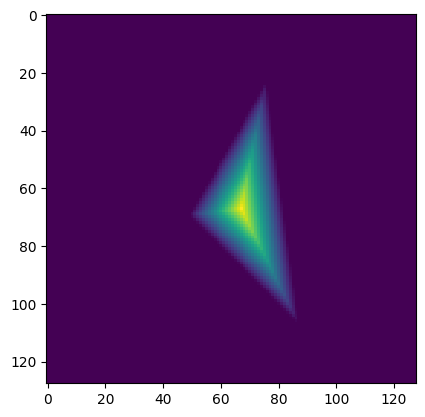

In [52]:
# Create a figure.
fig = plt.figure(num = 'Initial guess')

# Create a subplot.
ax = fig.add_subplot(1, 1, 1)

# Visualise the initial guess.
ax.imshow(
    visualise_triangle(T, bbox = [[-1, -1], [1, 1]], m = res + 1, n = res + 1)
)

# Show the coordinates of the resulting triangle, its lengths of edges and the
# approximation of the minimal Eigenvalue.
display(T.reshape((3, 2)))
display(edges_lengths(T))
display(nn_objective(T))

# Show the plot.
plt.show()


In [0]:
# Free the memory.
del fig
del ax


In [0]:
# Free the memory.
del min_l_0_triangle
del T


**Minimiziranje $ \lambda_{1} $ konvolucijskom neuronskom mrežom&hellip;**


In [55]:
min_l_0_triangle = opt.minimize(
    cnn_objective,
    T0,
    method = 'trust-constr',
    bounds = ((-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1)),
    constraints = (
        {'type' : 'ineq', 'fun' : minimal_edge},
        {'type' : 'eq', 'fun' : ok_circumference}
    )
)


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


In [0]:
T = correct_orientation(min_l_0_triangle.x)


array([[ 0.17892778, -0.35056956],
       [ 0.33674487,  0.37794302],
       [-0.78285047,  0.23472351]])

(0.7454105037487195, 1.1287185457994442, 1.125870950451836)

110.79842376708984

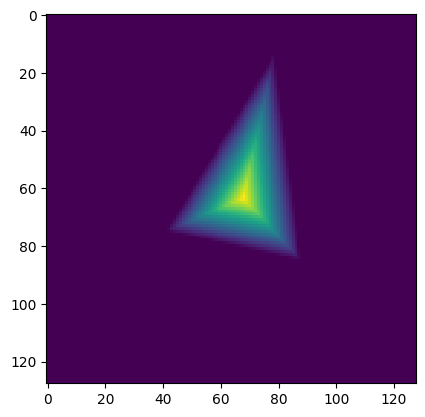

In [57]:
# Create a figure.
fig = plt.figure(num = 'Initial guess')

# Create a subplot.
ax = fig.add_subplot(1, 1, 1)

# Visualise the initial guess.
ax.imshow(
    visualise_triangle(T, bbox = [[-1, -1], [1, 1]], m = res + 1, n = res + 1)
)

# Show the coordinates of the resulting triangle, its lengths of edges and the
# approximation of the minimal Eigenvalue.
display(T.reshape((3, 2)))
display(edges_lengths(T))
display(cnn_objective(T))

# Show the plot.
plt.show()


In [0]:
# Free the memory.
del fig
del ax


In [0]:
# Free the memory.
del min_l_0_triangle
del T


In [0]:
# Free the memory.
del T0
del ok_circumference
del polynomial_4_objective
del polynomial_5_objective


## Zaključak <a class="anchor" id="conclusion"></a>


Očekivano, modeli koji su na najnižim vrijednostima najtočniji&mdash;polinomni modeli, to jest, modeli linearne regresije&mdash;najbolje su minimizirali vrijednosti na trokutima. Najveće je iznenađenje neuronska mreža koja vrijednosti minimizira na vidno tupokutnim trokutima. Konvolucijska neuronska mreža, iako loše predviđa vrijednost, trokut na kojem se taj minimum postiže solidno *pogađa*.


In [0]:
# Free the memory.
del polynomial_4
del polynomial_terms_4
del polynomial_5
del polynomial_terms_5
del nn
del X_mean
del X_std
del cnn
del res
